# Asynchronous fitness evaluation mathematicl experiemnts
This notebook explores the efficiency gain from asynchronous fitness function evaluation using fundamental mathemtics

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import pickle
import matplotlib.pyplot as plt
from distfit import distfit
from scipy import stats
from scipy import integrate
from tqdm import tqdm

# MILP Optimization API
from pyscipopt import Model

#Import helper functions
from opt_functions import (
    opt_bracket,
    get_results,
    brack_score,
    sigmoid
)

### Import relevant data

We'll need to import the data that will be used during the optimization. This includes:
* `data_frames`: This dictionary contains a dataframe of important data for each year. The information contained in these dataframes for each year are:
    * Probabilistic projections for each team in each round
    * Matrix representing the actual outcome of the tournament
    * Matrix representing the chalk outcome of the tournament
* `chalk_total_scores`: This dictionary contains the scores for the chalk brackets to be used during fitness function evaluation.
* `best_d`: This is the best distance vector from a previous run. Provides a starting point for the optimization. This is used as the starting point for creating random distance vectors

In [2]:
# Import relevant data for optimization

years = ["2014", "2015", "2016", "2017", "2018", "2019", "2021", "2022", "2023"]  #Years to be analyzied

# Import data frames with probabilities, chalk, and actual outcomes
cwd = os.getcwd()
file_path = "\Data\\final_bracket_data\\"
data_frames = {}
for year in years:
    data_frames[year] = pd.read_csv(cwd + file_path + year + ".csv")

#Record the scores for the chalk brackets
chalk_scores = {"2014": 690,
                "2015": 860,
                "2016": 990,
                "2017": 700,
                "2018": 1140,
                "2019": 950,
                "2021": 870,
                "2022": 790,
                "2023": 520}

# Extract the most recent best distances
with open('best_d_final.pkl', 'rb') as f:
    best_d = pickle.load(f)
f.close()

### Fitness function
The cell below defines the final fitness function that was used to generate the optimal distance vector. This is the function that is evaluated asynhronously in the genetic algorithm.
The fitness function is defined as $$F\left(\mathbf{X}_1^*, \mathbf{X}_2^*, \ldots, \mathbf{X}_K^*\right) = \sum_{k=1}^{K} \frac{1}{1 + e^{-\frac{\left(S\left(\mathbf{X}_k^*\right) - S\left(\mathbf{C}_k\right)\right)}{w}}}$$

In [4]:
def fitness_sigmoid(phenome):
    """
    Calculate fitness using sigmoid difference above chalk

    Parameters
    ----------
    phenome : list[float]
        distance vector

    Returns
    -------
    float
        fitness score
    """
    fitness = 0
    for year in data_frames.keys():
        output, x = opt_bracket(data_frames[year], phenome)
        results = get_results(output, x)
        diff = sum(brack_score(results, data_frames[year])) - chalk_scores[year]
        fitness += sigmoid(diff, 25)
    return fitness

### Generate distribution of solve times

* The first cell generated random distance vectors to generate brackets with. We will generate 250 distance vectors where the optimal distance vector is the center given we know that it works well and has a feasible solution that is not the original bracket
* The second cell runs the fitness function on the 250 distance vectors. The solve times are collected to determine the distribution of the solve times. Understanding the distribution is integral as its the random nature of the solve time that gives asynchronous evaluation its advantage.

In [5]:
mean = best_d
cov = np.eye(6)*((.1/3)**2)
d_s = np.random.multivariate_normal(mean=mean, cov=cov, size=250)

In [6]:
solve_times = []
for distance_vector in tqdm(d_s):
    start_time = time.time()
    fitness_sigmoid(distance_vector)
    solve_times.append(time.time()-start_time)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [49:31<00:00, 11.89s/it]


### Fitting a distribution to solve times

* We use the distfit package to fit a distrubtution to the solve time data
* The RSS value is the quality of fit. The lower the better

In [9]:
dist = distfit()
dist.fit_transform(np.array(solve_times))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.0 sec] [RSS: 0.00608137] [loc=11.885 scale=9.795]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00173199] [loc=1.757 scale=10.128]
[distfit] >INFO> [pareto    ] [0.0 sec] [RSS: 0.00173199] [loc=-536870910.243 scale=536870912.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.00266851] [loc=7.513 scale=6.072]
[distfit] >INFO> [t         ] [0.10 sec] [RSS: 0.00142198] [loc=6.838 scale=3.007]
[distfit] >INFO> [genextreme] [0.09 sec] [RSS: 0.000885561] [loc=6.588 scale=4.286]
[distfit] >INFO> [gamma     ] [0.03 sec] [RSS: 0.00162321] [loc=1.731 scale=8.651]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 0.00115239] [loc=0.999 scale=7.582]
[distfit] >INFO> [beta      ] [0.07 sec] [RSS: 0.00192424] [loc=1.757 scale=68.831]
[distfit] >INFO> [uniform   ] [0.0 sec] [RSS: 0.0103106] [loc=1.757 scale=55.416]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 0.00618832] [loc=-2785.349 scale=384.761]


{'model': {'name': 'genextreme',
  'score': 0.0008855609890922445,
  'loc': 6.587871324254245,
  'scale': 4.285891511305683,
  'arg': (-0.4831173886127428,),
  'params': (-0.4831173886127428, 6.587871324254245, 4.285891511305683),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2413025fed0>,
  'bootstrap_score': 0,
  'bootstrap_pass': None,
  'color': '#e41a1c',
  'CII_min_alpha': 2.937881771142978,
  'CII_max_alpha': 34.9712109948661},
 'summary':           name     score               loc        scale  \
 0   genextreme  0.000886          6.587871     4.285892   
 1      lognorm  0.001152          0.999325     7.582344   
 2            t  0.001422          6.838176     3.007359   
 3        gamma  0.001623           1.73088     8.650968   
 4       pareto  0.001732 -536870910.243333  536870912.0   
 5        expon  0.001732          1.756667    10.127948   
 6         beta  0.001924          1.756667    68.831382   
 7     dweibull  0.002669          7.513134 

### Selecting the distribution

* The strongest fitting distribution is the generalized extreme value distribution, followed by lognormal, t, and gamma distributions.
* Although these distributions have a strong fit, their mathematical form is a little more complicated and will be difficult to manipulate analytically in later sections.
* A good compromise is the exponential distribution which takes on the form $f(x; \lambda, \alpha, \beta) = \frac{1}{\beta} e^{-\frac{(x - \alpha)}{\beta}} \quad \text{for } x \geq \alpha, \lambda > 0$
    * This probability density function is easy to work with and has a good fit
    * $\alpha$ is the `loc` parameter which shifts the start of the distribution from 0
    * $\beta$ is the `scale` parameter which is a measure of spread for the distribution
    * $x$ in our study is the time. We will use $t$ from here on out

In [11]:
dist_exp = distfit(distr=['expon'])
results_exp = dist_exp.fit_transform(np.array(solve_times))
print(results_exp["model"])

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [expon] [0.00 sec] [RSS: 0.00173199] [loc=1.757 scale=10.128]


{'name': 'expon', 'score': 0.0017319914675471887, 'loc': 1.7566673755645752, 'scale': 10.127948221206665, 'arg': (), 'params': (1.7566673755645752, 10.127948221206665), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024130219990>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c', 'CII_min_alpha': 2.2761632052167977, 'CII_max_alpha': 32.09728872671711}


### Plotting the distribution

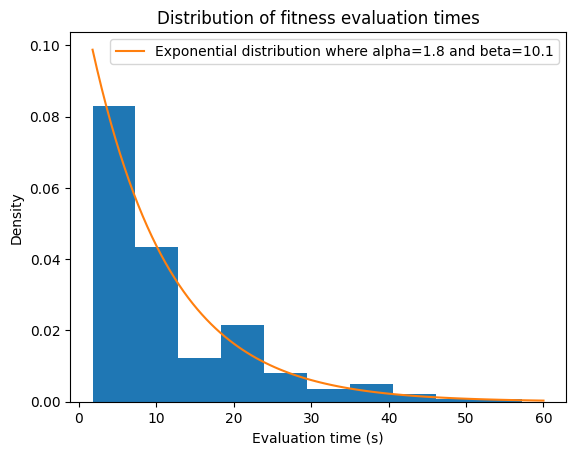

In [19]:
pdf_x = np.linspace(results_exp["model"]["loc"], 60, num=100)
alpha = results_exp["model"]["loc"]
beta = results_exp["model"]["scale"]
pdf_y = stats.expon.pdf(pdf_x, loc=alpha, scale=beta)
plt.hist(solve_times, bins=10, density=True)
plt.plot(pdf_x, pdf_y)
plt.title("Distribution of fitness evaluation times")
plt.xlabel("Evaluation time (s)")
plt.ylabel("Density")
plt.legend([f"Exponential distribution where alpha={round(alpha, 1)} and beta={round(beta, 1)}"])

### Formula for average solve time of $n$ fitness functions evaluated synchronously

As described in the appendix of the paper, we need to caclulate the average time it takes for $n$ functions to be evaluated synchronously. This is essentially the expectation of the time it takes for the last function to finish.  After some derivation, we arrive at the folling equation for the expectation:

$$E\left[t\right]=\int_{\alpha}^{\infty} \frac{nt}{\beta} \left(1-e^{-\frac{(t-\alpha)}{\beta}}\right)^{n-1} e^{-\frac{(t-\alpha)}{\beta}} \, dt$$

We'll elvauate this integral using the `integrate` class from scipy. The `integrate.quad()` method expects the first argument of the function being integrated to be the variable that is being integrated over and the following arguments to be other constants that you can set later. The integrand is defined below and evaluated at values of n from 1 to 20.

In [14]:
def integrand(t: float, loc: float, scale: float, n: int) -> float:
    """
    Integrand for the average timeof running n fitness functions synchronously

    Parameters
    ----------
    t : float
        time
    loc : float
        The location or aplha parameter of the exponential distribution
    scale : float
        The scale or beta parameter of the exponential distribution
    n : int
        The number of fitness functions being evaluated

    Returns
    -------
    float
        The value of the integrand
    """
    return t*(n/scale)*(1-np.exp(-(t-loc)/scale))**(n-1)*(np.exp(-(t-loc)/scale))

### Calculating and visualizing time to evaluate $n$ fitness functions synchronously

We now visualize the the behavior of synchronous fitness function evaluation under the exponential distribution. We can see that as the number of processors increases, it is more likely that one of the processes runs long. The behavior is less than linear. The more processors that are included, the more likely that ones runs longer but te amount of extra timee it takes is not linear. This is due to the shape of the exponential distribution.

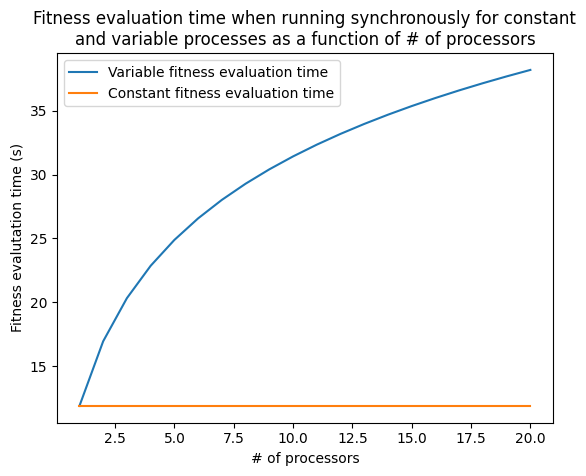

In [16]:
loc = results_exp["model"]["loc"]
scale = results_exp["model"]["scale"]
mean_times = []
num_points = 20
singular_mean = loc + scale
for n in range(1, num_points + 1):
    # Integrate expectation function from location to infinity
    mean_time_per_job = integrate.quad(integrand, loc, np.inf, args=(loc, scale, n))[0]

    # Record average time under an asynchronous lens
    mean_times.append(mean_time_per_job)

# Plot synchronous evaluation times
plt.plot(list(range(1,num_points + 1)), mean_times)
plt.plot(list(range(1,num_points + 1)), [singular_mean]*len(mean_times))
plt.title("Fitness evaluation time when running synchronously for constant\nand variable processes as a function of # of processors")
plt.xlabel("# of processors")
plt.ylabel("Fitness evalutation time (s)")
plt.legend(["Variable fitness evaluation time", "Constant fitness evaluation time"])

### Visualizing efficiency of synchronous vs. asynchronous evaluation

It's also useful to see the metric as fraction of time it would take to run the functions in series. Something interesting from the figure below is the gap being closed between asynchronous and synchronous evaluation. This is happenning due to the convex shape of the figure above. 

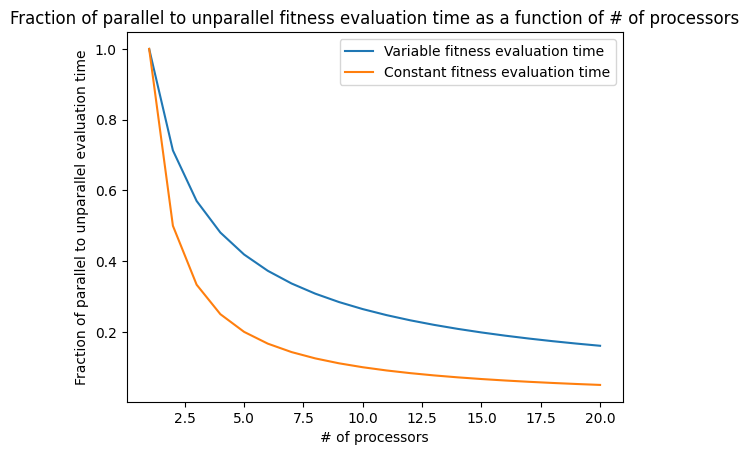

In [17]:
mean_times = []
num_points = 20
singular_mean = loc + scale
for n in range(1, num_points + 1):
    mean_time_per_job = integrate.quad(integrand, loc, np.inf, args=(loc, scale, n))[0]/n
    gain = mean_time_per_job/singular_mean
    mean_times.append(gain)
plt.plot(list(range(1,num_points + 1)), mean_times)
plt.plot(list(range(1,num_points + 1)), 1/np.array(list(range(1,num_points + 1))))
plt.title("Fraction of parallel to unparallel fitness evaluation time as a function of # of processors")
plt.xlabel("# of processors")
plt.ylabel("Fraction of parallel to unparallel evaluation time")
plt.legend(["Variable fitness evaluation time", "Constant fitness evaluation time"])